# Project 3: Music Recommendation

**Type:** Recommender System | **Level:** Intermediate

Build a music recommendation engine using collaborative filtering.

**Model:** Collaborative Filtering (User-Item Matrix)

**Dataset:** [Spotify Dataset](https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs) or [Last.fm](http://millionsongdataset.com/)

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Load the dataset
df = pd.read_csv('../data/music_rec/data_by_genres.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (2973, 14)

Column names:
['mode', 'genres', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key']

First few rows:


,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,20.859882,7
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7


## 3. Exploratory Data Analysis

Dataset Info:
Rows: 2973 genres
Columns: 14 features

Missing values: 0

Sample genres:
['21st century classical', '432hz', '8-bit', '[]', 'a cappella', 'abstract', 'abstract beats', 'abstract hip hop', 'accordeon', 'accordion']

Audio features statistics:
       acousticness  danceability       energy  instrumentalness     loudness  \
count   2973.000000   2973.000000  2973.000000       2973.000000  2973.000000   
mean       0.401241      0.537187     0.561143          0.211366   -10.509848   
std        0.319760      0.150668     0.234486          0.267329     5.369202   
min        0.000003      0.056900     0.001002          0.000000   -41.825000   
25%        0.119050      0.441202     0.395058          0.004835   -12.427656   
50%        0.321745      0.546496     0.601195          0.080700    -9.221817   
75%        0.673991      0.647500     0.730127          0.343333    -6.920125   
max        0.996000      0.929000     0.994667          0.992000     0.060000   

       speech

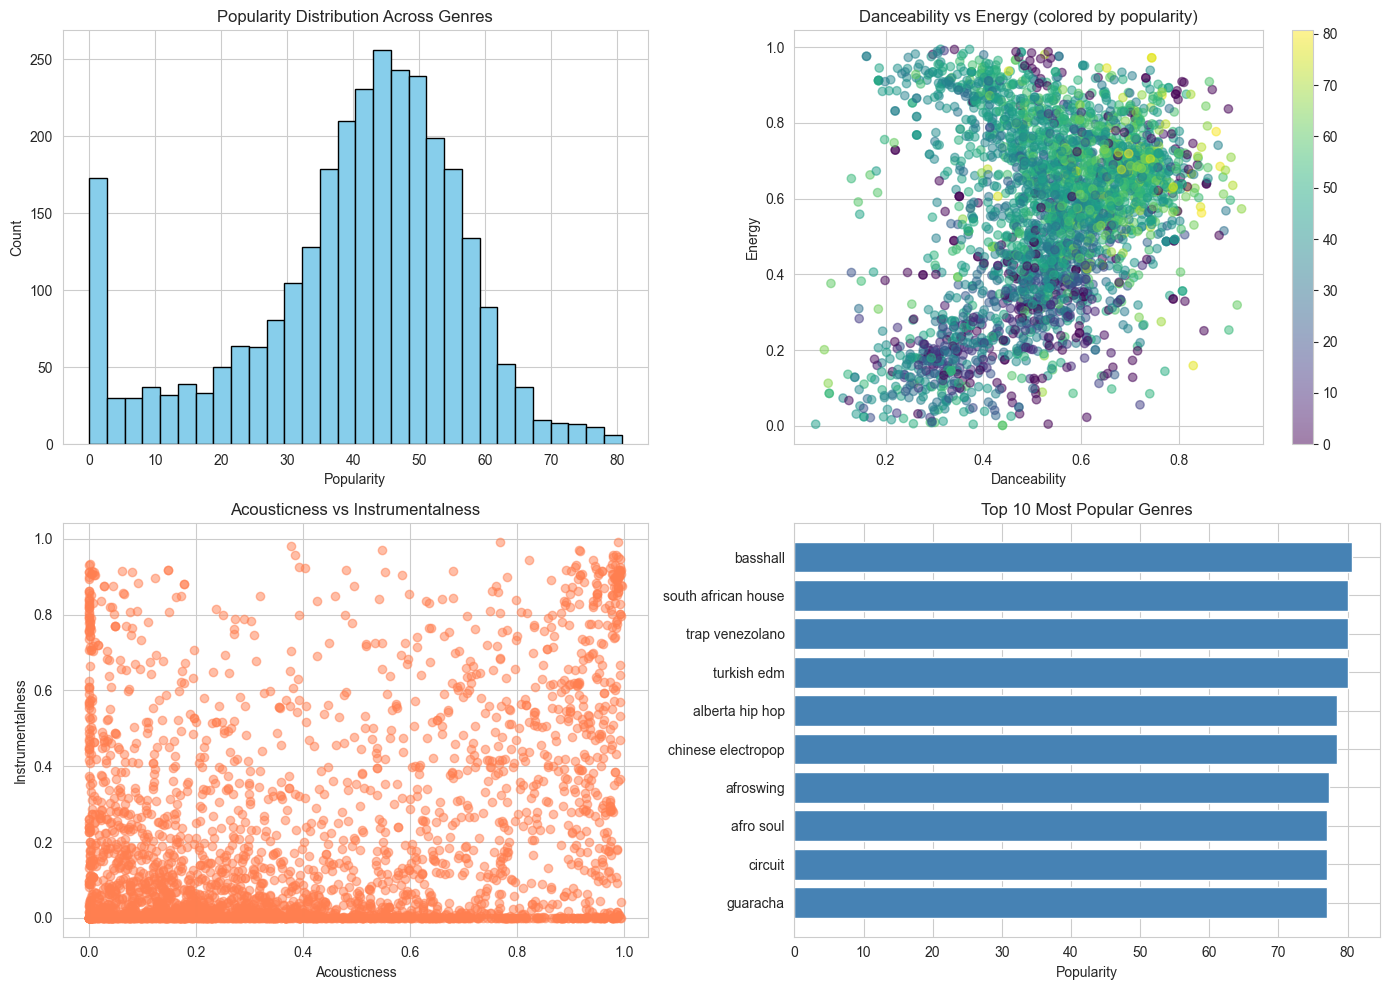

In [3]:
# Basic info
print("Dataset Info:")
print(f"Rows: {df.shape[0]} genres")
print(f"Columns: {df.shape[1]} features")
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nSample genres:")
print(df['genres'].head(10).tolist())

# Audio features summary
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                  'loudness', 'speechiness', 'tempo', 'valence']
print(f"\nAudio features statistics:")
print(df[audio_features].describe())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Popularity distribution
axes[0, 0].hist(df['popularity'], bins=30, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Popularity Distribution Across Genres')
axes[0, 0].set_xlabel('Popularity')
axes[0, 0].set_ylabel('Count')

# Danceability vs Energy
axes[0, 1].scatter(df['danceability'], df['energy'], alpha=0.5, c=df['popularity'], cmap='viridis')
axes[0, 1].set_title('Danceability vs Energy (colored by popularity)')
axes[0, 1].set_xlabel('Danceability')
axes[0, 1].set_ylabel('Energy')
axes[0, 1].colorbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])

# Acousticness vs Instrumentalness
axes[1, 0].scatter(df['acousticness'], df['instrumentalness'], alpha=0.5, color='coral')
axes[1, 0].set_title('Acousticness vs Instrumentalness')
axes[1, 0].set_xlabel('Acousticness')
axes[1, 0].set_ylabel('Instrumentalness')

# Top 10 popular genres
top_genres = df.nlargest(10, 'popularity')[['genres', 'popularity']]
axes[1, 1].barh(range(len(top_genres)), top_genres['popularity'].values, color='steelblue')
axes[1, 1].set_yticks(range(len(top_genres)))
axes[1, 1].set_yticklabels(top_genres['genres'].values)
axes[1, 1].set_title('Top 10 Most Popular Genres')
axes[1, 1].set_xlabel('Popularity')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [4]:
# Prepare data for recommendation
# Select audio features for similarity calculation
feature_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# Create feature matrix
X = df[feature_cols].copy()

# Normalize features (important for distance-based recommendations)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"\nFeatures used for recommendations:")
print(feature_cols)
print(f"\nScaled features sample (first genre):")
print(X_scaled[0])

Feature matrix shape: (2973, 9)

Features used for recommendations:
['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

Scaled features sample (first genre):
[ 1.80819676 -2.48471886 -2.08928314  1.47957496  1.82802928 -3.91268949
 -0.534628   -2.50095032 -1.92760907]


## 5. Model Training

In [5]:
# Build recommendation model using K-Nearest Neighbors
# This finds similar genres based on audio features

n_neighbors = 11  # Find 10 similar genres (plus the genre itself)
model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
model.fit(X_scaled)

print(f"Recommendation model trained!")
print(f"Using K-Nearest Neighbors with {n_neighbors-1} recommendations per genre")
print(f"Distance metric: Cosine similarity")
print(f"\nModel is ready to recommend similar genres based on audio features.")

Recommendation model trained!
Using K-Nearest Neighbors with 10 recommendations per genre
Distance metric: Cosine similarity

Model is ready to recommend similar genres based on audio features.


## 6. Model Evaluation


Recommendations for: ROCK
 rank          genre  similarity  popularity
    1        britpop    0.981567   48.105758
    2    sleaze rock    0.978088   37.435721
    3   philly indie    0.977068   49.293288
    4     glam metal    0.973955   38.716486
    5 socal pop punk    0.968869   47.146282


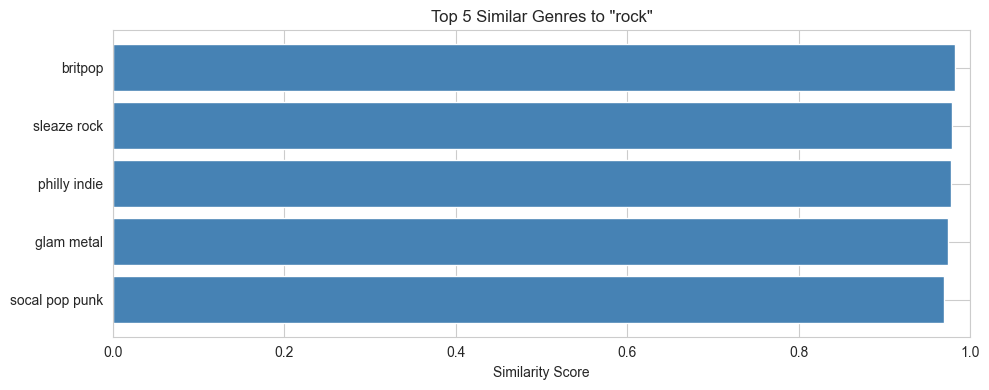


Recommendations for: HIP HOP
 rank              genre  similarity  popularity
    1       gangster rap    0.996692   45.859471
    2      bronx hip hop    0.995509   42.320893
    3     west coast rap    0.995303   45.359238
    4 east coast hip hop    0.992619   44.313585
    5   hardcore hip hop    0.990726   44.856905


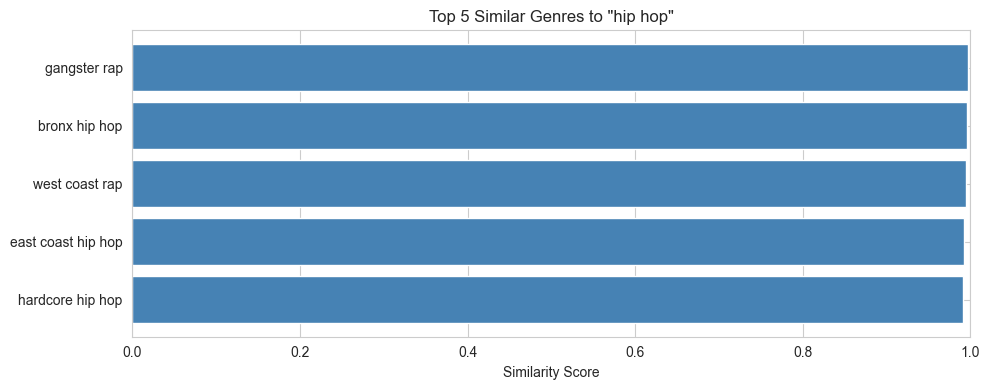


Recommendations for: JAZZ
 rank                 genre  similarity  popularity
    1             cool jazz    0.999451   20.266626
    2                 bebop    0.998881   20.291247
    3              hard bop    0.997161   19.005730
    4 contemporary post-bop    0.989380   24.715164
    5        jazz saxophone    0.986602   20.632092


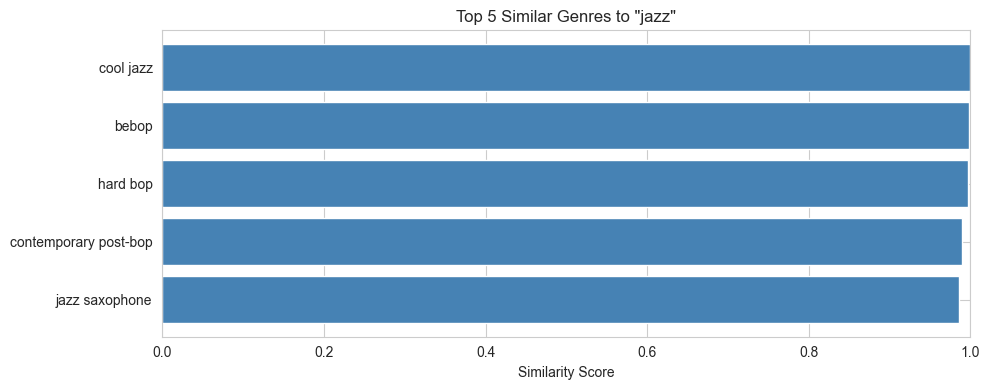


Genre 'electronic' not found in dataset


In [6]:
# Function to get recommendations
def get_recommendations(genre_name, n_recommendations=10):
    """
    Get similar genre recommendations based on audio features
    """
    # Find the genre in the dataset
    if genre_name not in df['genres'].values:
        return f"Genre '{genre_name}' not found in dataset"
    
    # Get the index of the genre
    idx = df[df['genres'] == genre_name].index[0]
    
    # Get the feature vector
    genre_features = X_scaled[idx].reshape(1, -1)
    
    # Find similar genres
    distances, indices = model.kneighbors(genre_features, n_neighbors=n_recommendations+1)
    
    # Create recommendations dataframe (skip the first one as it's the genre itself)
    recommendations = []
    for i in range(1, len(indices[0])):
        rec_idx = indices[0][i]
        similarity = 1 - distances[0][i]  # Convert distance to similarity
        recommendations.append({
            'rank': i,
            'genre': df.iloc[rec_idx]['genres'],
            'similarity': similarity,
            'popularity': df.iloc[rec_idx]['popularity']
        })
    
    return pd.DataFrame(recommendations)

# Test the recommendation system with a few genres
test_genres = ['rock', 'hip hop', 'jazz', 'electronic']

for genre in test_genres:
    if genre in df['genres'].values:
        print(f"\n{'='*60}")
        print(f"Recommendations for: {genre.upper()}")
        print('='*60)
        recs = get_recommendations(genre, n_recommendations=5)
        print(recs.to_string(index=False))
        
        # Visualize
        plt.figure(figsize=(10, 4))
        plt.barh(range(len(recs)), recs['similarity'], color='steelblue')
        plt.yticks(range(len(recs)), recs['genre'])
        plt.xlabel('Similarity Score')
        plt.title(f'Top 5 Similar Genres to "{genre}"')
        plt.xlim(0, 1)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nGenre '{genre}' not found in dataset")

## 7. Save Model

In [7]:
# Save the recommendation system
model_path = '../models/music_recommendation_model.pkl'
joblib.dump(model, model_path)
print(f"✓ Model saved to: {model_path}")

# Save scaler and feature info
recommendation_data = {
    'scaler': scaler,
    'feature_cols': feature_cols,
    'genres': df['genres'].tolist(),
    'features_scaled': X_scaled,
    'df': df
}
data_path = '../models/music_recommendation_data.pkl'
joblib.dump(recommendation_data, data_path)
print(f"✓ Recommendation data saved to: {data_path}")

print("\n" + "="*60)
print("Music Recommendation System Complete!")
print("="*60)
print(f"\nTotal genres in database: {len(df)}")
print(f"Features used: {len(feature_cols)}")
print(f"Recommendation method: K-Nearest Neighbors (Cosine Similarity)")

print("\n" + "="*60)
print("Example Usage:")
print("="*60)
print("""
# Load the model and data
import joblib
model = joblib.load('../models/music_recommendation_model.pkl')
data = joblib.load('../models/music_recommendation_data.pkl')

# Get recommendations for a genre
genre = 'rock'
idx = data['genres'].index(genre)
genre_features = data['features_scaled'][idx].reshape(1, -1)
distances, indices = model.kneighbors(genre_features, n_neighbors=6)

# Display recommendations
for i in range(1, len(indices[0])):
    rec_idx = indices[0][i]
    print(f"{i}. {data['genres'][rec_idx]}")
""")

✓ Model saved to: ../models/music_recommendation_model.pkl
✓ Recommendation data saved to: ../models/music_recommendation_data.pkl

Music Recommendation System Complete!

Total genres in database: 2973
Features used: 9
Recommendation method: K-Nearest Neighbors (Cosine Similarity)

Example Usage:

# Load the model and data
import joblib
model = joblib.load('../models/music_recommendation_model.pkl')
data = joblib.load('../models/music_recommendation_data.pkl')

# Get recommendations for a genre
genre = 'rock'
idx = data['genres'].index(genre)
genre_features = data['features_scaled'][idx].reshape(1, -1)
distances, indices = model.kneighbors(genre_features, n_neighbors=6)

# Display recommendations
for i in range(1, len(indices[0])):
    rec_idx = indices[0][i]
    print(f"{i}. {data['genres'][rec_idx]}")

